# Revised Notebook

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
from shapely.geometry import Point, Polygon

import shapely.speedups #For point in polygon calculations
shapely.speedups.enable()

import json # library to handle JSON files

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import lonlat, distance # distance converter

# import K Nearest Neightbors
from sklearn.neighbors import KNeighborsClassifier

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

import requests # library to handle requests

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe#

## Geographic Data 
### Minneapolis Data

In [2]:
# Data retrieved from
# https://opendata.minneapolismn.gov/datasets/minneapolis-neighborhoods
# Data downloaded and placed in local directory.

with open('Minneapolis_Neighborhoods.geojson.json') as jsondata:
    mpls_data = json.load(jsondata)
    
#with open('Communities.geojson') as jsondata:
 #   mpls_comm_data = json.load(jsondata)
    
with open('stp_neighborhoods.geojson') as jsondata:
    stp_nbhd_data = json.load(jsondata)
    
# We will refer back to the larger mpls_data dataframe later.
mpls_nbhds = mpls_data['features']
#mpls_comms = mpls_comm_data['features']
stp_nbhds = stp_nbhd_data['features']

# Initalize the dataframe
column_names = ['Neighborhood','Latitude', 'Longitude']
df_nbhds_mpls = pd.DataFrame(columns=column_names)

# Fill in the neighborhood names. The latitude and longitude are filled in the next step.
for data in mpls_nbhds:
    nbhd_name = data['properties']['BDNAME']
    df_nbhds_mpls = df_nbhds_mpls.append({'Neighborhood':nbhd_name}, ignore_index=True)

# Populate lat/lon values for neighborhoods. Gather values not found by Geopy.
missing_latlons = []
for nbhd in df_nbhds_mpls['Neighborhood']:
    address = nbhd + ', Minneapolis, MN'
    geolocator = Nominatim(user_agent="mn_explorer")
    location = geolocator.geocode(address, timeout=10)
    if location is None:
        print(address+' is not found on geopy.')
        missing_latlons = missing_latlons +[nbhd]
    else:
        df_nbhds_mpls.loc[df_nbhds_mpls.index[df_nbhds_mpls['Neighborhood'] == nbhd].to_list(),'Latitude']= location.latitude
        df_nbhds_mpls.loc[df_nbhds_mpls.index[df_nbhds_mpls['Neighborhood'] == nbhd].to_list(),'Longitude']= location.longitude
    
print(missing_latlons)
#df_nbhds_mpls.head()


Downtown West, Minneapolis, MN is not found on geopy.
Ventura Village, Minneapolis, MN is not found on geopy.
South Uptown, Minneapolis, MN is not found on geopy.
Mid - City Industrial, Minneapolis, MN is not found on geopy.
Nicollet Island - East Bank, Minneapolis, MN is not found on geopy.
['Downtown West', 'Ventura Village', 'South Uptown', 'Mid - City Industrial', 'Nicollet Island - East Bank']


In [3]:
# Manually look up missing lat/lon values for these neighborhoods.
Downtown_West =[44.9742, -93.2733]
Ventura_Village = [44.9618, -93.2582]
# This neighborhood is now found on geopy...
#Humboldt_Industrial_Area = [45.0421, -93.3077]
South_Uptown = [44.9411, -93.2911]
Mid_City_Industrial = [44.9989, -93.2178]
Nicollet_Island = [44.9879, -93.2629]

missing_mpls = [Downtown_West, Ventura_Village, South_Uptown, Mid_City_Industrial, Nicollet_Island]

# Populate dictionary of neighborhoods and missing lat/long values
missing_dict={}
for j in range(0,len(missing_mpls)):
    entry ={missing_latlons[j]:missing_mpls[j]}
    missing_dict.update(entry)


# Fill in missing lat/long values into our dataframe
for j in range(0,len(missing_mpls)):
    value=df_nbhds_mpls.index[df_nbhds_mpls['Neighborhood']==missing_latlons[j]]
    df_nbhds_mpls.loc[value[0], 'Latitude'] = missing_dict[missing_latlons[j]][0]
    df_nbhds_mpls.loc[value[0], 'Longitude'] = missing_dict[missing_latlons[j]][1]




### Repeat for St. Paul

In [4]:
# Initalize the dataframe
column_names = ['Neighborhood','Latitude', 'Longitude']
df_nbhds_stp = pd.DataFrame(columns=column_names)


# Fill in the neighborhood names. The latitude and longitude are filled in the next step.
for data in stp_nbhds:
    nbhd_name = data['properties']['name2']
    df_nbhds_stp = df_nbhds_stp.append({'Neighborhood':nbhd_name}, ignore_index=True)
    
# Populate Lat/Long using Geopy
missing_latlons = []
for nbhd in df_nbhds_stp['Neighborhood']:
    address = nbhd + ', St. Paul, MN'
    geolocator = Nominatim(user_agent="mn_explorer")
    location = geolocator.geocode(address, timeout=10)
    if location is None:
        print(address+' is not found on geopy.')
        missing_latlons = missing_latlons +[nbhd]
    else:
        df_nbhds_stp.loc[df_nbhds_stp.index[df_nbhds_stp['Neighborhood'] == nbhd].to_list(),'Latitude']= location.latitude
        df_nbhds_stp.loc[df_nbhds_stp.index[df_nbhds_stp['Neighborhood'] == nbhd].to_list(),'Longitude']= location.longitude

print(missing_latlons)

Macalester-Groveland, St. Paul, MN is not found on geopy.
West Side Community Organization, St. Paul, MN is not found on geopy.
Summit Hill Association, St. Paul, MN is not found on geopy.
Summit-University, St. Paul, MN is not found on geopy.
Thomas-Dale/Frogtown, St. Paul, MN is not found on geopy.
West 7th Federation/Fort Road, St. Paul, MN is not found on geopy.
CapitolRiver Council, St. Paul, MN is not found on geopy.
Payne-Phalen, St. Paul, MN is not found on geopy.
The Greater East Side, St. Paul, MN is not found on geopy.
Eastview-Conway-Battle Creek-Highwood Hills, St. Paul, MN is not found on geopy.
Union Park, St. Paul, MN is not found on geopy.
['Macalester-Groveland', 'West Side Community Organization', 'Summit Hill Association', 'Summit-University', 'Thomas-Dale/Frogtown', 'West 7th Federation/Fort Road', 'CapitolRiver Council', 'Payne-Phalen', 'The Greater East Side', 'Eastview-Conway-Battle Creek-Highwood Hills', 'Union Park']


In [36]:
# In addition to the below missing neighborhoods, the North End neighborhood in St. Paul is
# found to be in England by geopy. So we manually add those correct coordinates too.

mac_grove=[44.9343,-93.1670]
west_side_comm_org=[44.9298, -93.0780]
summit_hill = [44.9399, -93.1364]
summit_uni = [44.9518, -93.1263]
thomas_dale_frogtown = [44.9594, -93.1212]
west_seventh = [44.9277, -93.1270]
capitol_river_council = [44.9512, -93.0952]
payne_phalen = [44.9775, -93.0660]
greater_east_side = [44.9741, -93.0240]
eastview_conway = [44.9525, -93.0117]
union_park = [44.9484, -93.1746]
north_end = [44.9774, -93.1059]

missing_stp = [mac_grove, west_side_comm_org, summit_hill, summit_uni, thomas_dale_frogtown, west_seventh,
             capitol_river_council, payne_phalen, greater_east_side, eastview_conway, union_park]

# Populate dictionary of neighborhoods and missing lat/long values
missing_dict={}
for j in range(0,len(missing_stp)):
    entry ={missing_latlons[j]:missing_stp[j]}
    missing_dict.update(entry)

# Fill in missing lat/long values into our dataframe
for j in range(0,len(missing_stp)):
    value=df_nbhds_stp.index[df_nbhds_stp['Neighborhood']==missing_latlons[j]]
    df_nbhds_stp.loc[value[0], 'Latitude'] = missing_dict[missing_latlons[j]][0]
    df_nbhds_stp.loc[value[0], 'Longitude'] = missing_dict[missing_latlons[j]][1]

df_nbhds_stp['Latitude'][2]=north_end[0]
df_nbhds_stp['Longitude'][2]=north_end[1]
    
df_nbhds_stp.head()

,Neighborhood,Latitude,Longitude
0,St Anthony Park,44.9792,-93.1935
1,Como,44.9759,-93.1313
2,North End,44.9774,-93.1059
3,Hamline-Midway,44.9629,-93.1669
4,Macalester-Groveland,44.9343,-93.167


In [35]:
df_nbhds_stp['Latitude'][2]

53.743243449999994

### Concat the neighborhoods

In [19]:
nbhds = pd.concat([df_nbhds_mpls,df_nbhds_stp]).reset_index(drop=True)

## Gather brewery and restaurant data
### Use Foursquare API to gather brewery data

In [43]:
# Will drop these columns from the search results.
drop_columns = ['referralId', 'reasons.count', 'reasons.items', 'venue.location.labeledLatLngs',
                'venue.photos.count', 'venue.photos.groups', 'venue.location.postalCode',
                'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country',
                'venue.location.formattedAddress', 'venue.venuePage.id', 'venue.delivery.id', 'venue.delivery.url',
                'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix', 'venue.delivery.provider.icon.sizes',
                'venue.delivery.provider.icon.name', 'venue.location.neighborhood', 'venue.categories',
                'venue.location.distance', 'venue.location.crossStreet']


# Define FourSquare credentials
CLIENT_ID = 'JSN5MX1DKF5XI3CXVZADJMU5LZE5FMLT2COF00LRJDFMFWIK' # your Foursquare ID
CLIENT_SECRET = 'ZST1WYPJCG2J2LGQGUER23BPAC1OMF1BKYC4WQKSSRD3WC1T' # your Foursquare Secret
VERSION = '20200801' # Foursquare API version

category = '50327c8591d4c4b30a586d5d' # Foursquare category for brewery
radius = 3500 # in meters
LIMIT = 200

# Initialize df_brew
df_brew =pd.DataFrame(columns=['venue.id', 'venue.name', 'venue.location.address',
       'venue.location.lat', 'venue.location.lng'])

# Look at area centered at each of the neighbhorhood lat/lon coordinates.
# Do FourSquare API call for each neighborhood, locating breweries. Store results in df_brew.
for j in range(0,len(nbhds)):
    lat=nbhds.loc[j,'Latitude']
    lon=nbhds.loc[j,'Longitude']
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, LIMIT)
    results=requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    df_temp = pd.json_normalize(venues)
    df_brew = pd.concat([df_brew, df_temp])

# Drop unwanted columns, eliminate duplicates, reset index to arrive at final df_brew dataframe.    
df_brew.drop(columns=drop_columns, inplace=True)
df_brew.drop_duplicates(inplace=True)
df_brew.reset_index(inplace=True)
df_brew.drop(columns='index', inplace=True)
print(df_brew.shape)
df_brew.head()

j is  0 . lat is  44.9538581 . lon is  -93.266298
j is  1 . lat is  44.9742 . lon is  -93.2733
j is  2 . lat is  44.9749768 . lon is  -93.2599336
j is  3 . lat is  44.9618 . lon is  -93.2582
j is  4 . lat is  44.9837127 . lon is  -93.2914054
j is  5 . lat is  45.0363229 . lon is  -93.2929179
j is  6 . lat is  45.0434636 . lon is  -93.2921661
j is  7 . lat is  45.0299229 . lon is  -93.2948268
j is  8 . lat is  45.0105656 . lon is  -93.2693041
j is  9 . lat is  45.0316525 . lon is  -93.3151902
j is  10 . lat is  44.94865 . lon is  -93.30077
j is  11 . lat is  44.9367168 . lon is  -93.2159479
j is  12 . lat is  44.9240436 . lon is  -93.2121333
j is  13 . lat is  44.8987487 . lon is  -93.2825491
j is  14 . lat is  44.921725 . lon is  -93.2318907
j is  15 . lat is  44.9168278 . lon is  -93.2684148
j is  16 . lat is  44.907684 . lon is  -93.2682177
j is  17 . lat is  44.92464675 . lon is  -93.31111431693155
j is  18 . lat is  44.9685112 . lon is  -93.244918
j is  19 . lat is  44.96752735 . l

,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng
0,538bf392498e382b6fa108b4,Eastlake Craft Brewery,920 E Lake St #123,44.948491,-93.260416
1,56242508498e6aeb80142c2c,Lakes & Legends Brewing Company,1368 Lasalle Ave,44.968908,-93.279479
2,52e6ad8c498efd5a184d1105,LynLake Brewery,2934 Lyndale Ave S,44.948919,-93.288345
3,5aa9baebff03062a4b1dccba,Finnegans House,817 5th Ave S,44.972301,-93.266410
4,52d4225b498e07070c180a62,Sisyphus Brewing,712 Ontario Ave W,44.973214,-93.289040


In [44]:
# Drop the following venues from df_brew.
venue_brew_drop = {'Metro Warehouse Liquor', 'Pizza Lucé', 'SiP Coffee Bar', 'Spyhouse Coffee'}
for j in venue_brew_drop:
    df_brew.drop(df_brew.index[df_brew['venue.name']==j], inplace=True)
df_brew.reset_index(drop=True,inplace=True)

### Use Foursquare API to gather restaurant data

In [45]:
# Will drop these columns from the search results.
drop_columns = ['referralId', 'reasons.count', 'reasons.items', 'venue.location.labeledLatLngs',
                'venue.photos.count', 'venue.photos.groups', 'venue.location.postalCode',
                'venue.location.cc', 'venue.location.city', 'venue.location.state', 'venue.location.country',
                'venue.location.formattedAddress', 'venue.venuePage.id', 'venue.delivery.id', 'venue.delivery.url',
                'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix', 'venue.delivery.provider.icon.sizes',
                'venue.delivery.provider.icon.name', 'venue.location.neighborhood', 'venue.categories',
                'venue.location.distance', 'venue.location.crossStreet']

category = '4d4b7105d754a06374d81259' # Foursquare category for food (restaurants)
radius = 2000 # in meters
LIMIT = 200

# Initialize df_food
df_food =pd.DataFrame(columns=['venue.id', 'venue.name', 'venue.location.address',
       'venue.location.lat', 'venue.location.lng'])

# Look at a 2 km radius area centered at each of the Minneapolis neighbhorhoods.
# Do FourSquare API call for each neighborhood, locating restaurants. Store results in df_food.
counter = 0
for j in range(0,len(df_nbhds_mpls)):
    lat=df_nbhds_mpls.loc[j,'Latitude']
    print('j is ',j,' and lat is ', lat)
    lon=df_nbhds_mpls.loc[j,'Longitude']
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, LIMIT)
    results=requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    df_temp = pd.json_normalize(venues)
#    print('df_temp shape is', df_temp.shape, '. Counter is ', counter)
    df_food = pd.concat([df_food, df_temp])
    #print(counter)
    #counter+=1
    
# Repeat above call but with St. Paul neighborhoods. Increase the radius size.
radius = 3500
counter = 0
for j in range(0,len(df_nbhds_stp)):
    lat=df_nbhds_stp.loc[j,'Latitude']
    lon=df_nbhds_stp.loc[j,'Longitude']
    url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'\
        .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, category, radius, LIMIT)
    results=requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    df_temp = pd.json_normalize(venues)
    #print('df_temp shape is', df_temp.shape, '. Counter is ', counter)
    df_food = pd.concat([df_food, df_temp])
    #print(counter)
    counter+=1

# Drop unwanted columns, eliminate duplicates, reset index to arrive at final df_food dataframe.    
df_food.drop(columns=drop_columns, inplace=True)
df_food.drop_duplicates(inplace=True)
df_food.reset_index(drop=True, inplace=True)
print(df_food.shape)
df_food.head()

j is  0  and lat is  44.9538581
j is  1  and lat is  44.9742
j is  2  and lat is  44.9749768
j is  3  and lat is  44.9618
j is  4  and lat is  44.9837127
j is  5  and lat is  45.0363229
j is  6  and lat is  45.0434636
j is  7  and lat is  45.0299229
j is  8  and lat is  45.0105656
j is  9  and lat is  45.0316525
j is  10  and lat is  44.94865
j is  11  and lat is  44.9367168
j is  12  and lat is  44.9240436
j is  13  and lat is  44.8987487
j is  14  and lat is  44.921725
j is  15  and lat is  44.9168278
j is  16  and lat is  44.907684
j is  17  and lat is  44.92464675
j is  18  and lat is  44.9685112
j is  19  and lat is  44.96752735
j is  20  and lat is  44.97308605
j is  21  and lat is  45.0091288
j is  22  and lat is  45.0057002
j is  23  and lat is  44.9942242
j is  24  and lat is  44.9922871
j is  25  and lat is  44.9811469
j is  26  and lat is  44.97008875
j is  27  and lat is  44.9645127
j is  28  and lat is  44.9097061
j is  29  and lat is  44.8985811
j is  30  and lat is  44.9

,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng
0,44b492d9f964a52057351fe3,Midtown Global Market,920 E Lake St,44.948589,-93.260502
1,49fb95f5f964a5205d6e1fe3,Taqueria La Hacienda,334 E Lake St #101,44.948605,-93.271181
2,44f1f813f964a5200a381fe3,Quang Restaurant,2719 Nicollet Ave,44.953136,-93.277745
3,50255babe4b0bc802b45360b,FIKA,2600 Park Ave,44.954555,-93.265717
4,49e4c13ef964a52034631fe3,Manny's Tortas,920 E Lake St,44.948679,-93.260649


### Concatenate the brewery and restaurant dataframes

In [46]:
# type variable set to 0 for restaurants
df_food['type'] = pd.Series(np.zeros(len(df_food)))

# type variable set to 1 for breweries
df_brew['type'] = pd.Series(np.ones(len(df_brew)))

In [47]:
df = pd.concat([df_food, df_brew]).reset_index(drop=True)
print(df.shape)
df.head(3)

(1664, 6)


,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,type
0,44b492d9f964a52057351fe3,Midtown Global Market,920 E Lake St,44.948589,-93.260502,0.0
1,49fb95f5f964a5205d6e1fe3,Taqueria La Hacienda,334 E Lake St #101,44.948605,-93.271181,0.0
2,44f1f813f964a5200a381fe3,Quang Restaurant,2719 Nicollet Ave,44.953136,-93.277745,0.0


## Assign neighborhoods to breweries and restaurants
We will turn our dataframes into geodataframes in order to use the geopandas methods. Two metrics we want to add to our dataframe is distance to nearest brewery and number of restaurants/breweries in a fixed radius. We can build a ratio with this: brewery count/restaurant count.
### Construct geodataframes of neighborhoods

In [190]:
# Make Minneapolis neighborhoods
mpls_nbhd_geo = gpd.read_file('Minneapolis_Neighborhoods.geojson.json', crs={'init':'epsg:4326'})
mpls_nbhd_geo = mpls_nbhd_geo[['geometry', 'BDNAME']]
mpls_nbhd_geo['city']=pd.Series(['Minneapolis']*len(mpls_nbhd_geo))

# Minneapolis communities are closer in size to the St. Paul neighborhoods.
# If we prefer to consider Minneapolis communities and St. Paul neighborhoods, comment the above code and
# run the following instead.

#mpls_comm_geo = gpd.read_file('Communities.geojson')
#mpls_comm_geo = mpls_comm_geo[['geometry', 'CommName']]
#mpls_comm_geo['city']=pd.Series(['Minneapolis']*len(mpls_comm_geo))
#mpls_comm_geo.rename(columns={'CommName':'BDNAME'}, inplace=True) # Rename so columns match

# Make St. Paul neighborhoods
stp_geo = gpd.read_file('stp_neighborhoods.geojson', crs={'init':'epsg:4326'})
stp_geo = stp_geo[['geometry', 'name2']]
stp_geo.rename(columns={'name2':'BDNAME'}, inplace=True) # Rename so columns match
stp_geo['city']=pd.Series(['St. Paul']*len(stp_geo))

# Combine to twin cities neighborhoods
tc_geo=pd.concat([mpls_nbhd_geo, stp_geo]).drop_duplicates().reset_index(drop=True)

# epsg code found at following link
# https://spatialreference.org/ref/?search=minnesota

tc_geo.to_crs(epsg=3596,inplace=True) # Use projected coordinate system to compute distances.
print(tc_geo.shape)
#tc_geo.head()

(104, 3)


In [191]:
# Turn df_brew into geodataframe
df_brew_geo = gpd.GeoDataFrame(df_brew.copy(), 
                               geometry=gpd.points_from_xy(df_brew['venue.location.lng'],
                                                           df_brew['venue.location.lat']),
                              crs={'init':'epsg:4326'}) # Projects lat/long coords so that distance can be computed
# epsg=32633 is UTM projection
df_brew_geo.to_crs(epsg=3596,inplace=True)


# Turn df_food into geodataframe
df_food_geo = gpd.GeoDataFrame(df_food.copy(), 
                               geometry=gpd.points_from_xy(df_food['venue.location.lng'], 
                                                           df_food['venue.location.lat']),
                              crs={'init':'epsg:4326'})
df_food_geo.to_crs(epsg=3596,inplace=True)

df_food_geo['neighborhood']=pd.Series(np.zeros(len(df_food)))
df_brew_geo['neighborhood']=pd.Series(np.zeros(len(df_brew)))

brewery_count=[]
food_count=[]
for j in range(0,len(tc_geo)):
    nbhd = tc_geo.loc[j,'BDNAME']  # nbhd is jth neighborhood name, string
    nbhd_geo = tc_geo[tc_geo['BDNAME'] == nbhd]  # nbhd_geo is jth row
    nbhd_geo.reset_index(drop=True, inplace=True)  # reset index of dataframe
    brew_mask = df_brew_geo['geometry'].within(nbhd_geo.loc[0,'geometry'])  # Boolean mask of breweries in nbhd.
    food_mask = df_food_geo['geometry'].within(nbhd_geo.loc[0,'geometry'])  # Boolean mask of restaurants in nbhd.
    
    # Add neighborhood columns to df_food
    df_food_geo['neighborhood'].mask(food_mask, other=nbhd, inplace=True)
    food_count.append(sum(food_mask))  # create list of brewery counts per neighborhood.

    # Add neighborhood column to df_brew.
    df_brew_geo['neighborhood'].mask(brew_mask, other=nbhd, inplace=True)
    brewery_count.append(sum(brew_mask))  # create list of brewery counts per neighborhood.


# Add column to tc_geo    
tc_geo['Restaurant Count'] = pd.Series(food_count) # add brewery count column        
    
# Add column to tc_geo    
tc_geo['Brewery Count'] = pd.Series(brewery_count) # add brewery count column
tc_geo.tail(2)

/Users/no50free/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,geometry,BDNAME,city,Restaurant Count,Brewery Count
102,"MULTIPOLYGON (((874982.787 313715.755, 874847....",Eastview-Conway-Battle Creek-Highwood Hills,St. Paul,27,1
103,"MULTIPOLYGON (((867350.803 316065.961, 866948....",Union Park,St. Paul,21,0


In [192]:
df_brew_geo['x']=df_brew_geo.geometry.x
df_brew_geo['y']=df_brew_geo.geometry.y
df_brew_geo.head(2)

,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,type,geometry,neighborhood,x,y
0,538bf392498e382b6fa108b4,Eastlake Craft Brewery,920 E Lake St #123,44.948491,-93.260416,1.0,POINT (858362.486 316766.792),Midtown Phillips,858362.485564,316766.792332
1,56242508498e6aeb80142c2c,Lakes & Legends Brewing Company,1368 Lasalle Ave,44.968908,-93.279479,1.0,POINT (856838.218 319022.100),Loring Park,856838.217710,319022.100108


In [193]:
df_food_geo['x']=df_food_geo.geometry.x
df_food_geo['y']=df_food_geo.geometry.y
df_food_geo.head(2)

,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,type,geometry,neighborhood,x,y
0,44b492d9f964a52057351fe3,Midtown Global Market,920 E Lake St,44.948589,-93.260502,0.0,POINT (858355.610 316777.581),Midtown Phillips,858355.610106,316777.580819
1,49fb95f5f964a5205d6e1fe3,Taqueria La Hacienda,334 E Lake St #101,44.948605,-93.271181,0.0,POINT (857512.917 316771.862),Phillips West,857512.916833,316771.861990


## Distance to closest brewery
Here we add a column to the restaurant/brewery data frame indicating distance to closest brewery. By default, breweries will have distance zero to the nearest breweries.

In [194]:
df_food_geo['nearest_brew']=np.zeros(len(df_food_geo))
df_food_geo['nearest_brew_name']=[None]*len(df_food_geo)

for j in range(len(df_food_geo)):
    brew_distances=df_brew_geo['geometry'].distance(other=df_food_geo.loc[j,'geometry'])/1000
    dex=list(brew_distances).index(min(brew_distances))
    df_food_geo.loc[j,'nearest_brew']=brew_distances.min()
    df_food_geo.loc[j,'nearest_brew_name']=df_brew_geo.loc[dex,'venue.name']
    
df_food_geo.head(3)    

,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,type,geometry,neighborhood,x,y,nearest_brew,nearest_brew_name
0,44b492d9f964a52057351fe3,Midtown Global Market,920 E Lake St,44.948589,-93.260502,0.0,POINT (858355.610 316777.581),Midtown Phillips,858355.610106,316777.580819,0.012793,Eastlake Craft Brewery
1,49fb95f5f964a5205d6e1fe3,Taqueria La Hacienda,334 E Lake St #101,44.948605,-93.271181,0.0,POINT (857512.917 316771.862),Phillips West,857512.916833,316771.861990,0.849584,Eastlake Craft Brewery
2,44f1f813f964a5200a381fe3,Quang Restaurant,2719 Nicollet Ave,44.953136,-93.277745,0.0,POINT (856990.543 317270.725),Whittier,856990.543130,317270.725336,0.936148,The Herkimer Pub & Brewery


### Count number of breweries in fixed radius

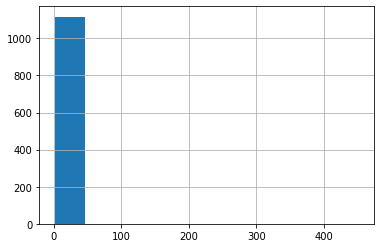

In [272]:


df_food_geo['within_r']=[0.0]*len(df_food_geo)
radius = 1.5

for j in range(len(df_food_geo)):
    brew_distances=df_brew_geo['geometry'].distance(other=df_food_geo.loc[j,'geometry'])/1000
    df_food_geo.loc[j,'within_r']=sum([True for x in brew_distances if x<radius])
# scale numbers. Numbers with higher counts are closer together. Numb   
#    df_food_geo['within_r']=np.log(df_food_geo['within_r']+1)
    
#df_food_geo.head(5)
df_food_geo['within_r'].value_counts()

## Cluster restaurants and breweries using KMeans

In [216]:
import random 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
%matplotlib inline

from sklearn.preprocessing import StandardScaler


X = df_food_geo[['x','y','nearest_brew','within_r']].values[:,:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.45652246, -0.23953138, -1.25295031, -0.56157302],
       [-0.58556407, -0.24094569, -0.31135897,  0.18344507],
       [-0.66555514, -0.11757291, -0.21395331,  0.43178444],
       ...,
       [ 2.86758262, -0.13455613,  2.17676099, -0.80991238],
       [ 2.86988764, -0.35171187,  2.6306386 , -0.80991238],
       [ 0.41260448,  0.10347957, -0.84928276,  1.17680253]])

In [230]:
clusterNum = 16
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 30)
k_means.fit(X)
labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

df_food_geo["Clus_km"] = labels
df_food_geo.head(2)


,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,type,geometry,neighborhood,x,y,nearest_brew,nearest_brew_name,within2.5,Clus_km,within_r
0,44b492d9f964a52057351fe3,Midtown Global Market,920 E Lake St,44.948589,-93.260502,0.0,POINT (858355.610 316777.581),Midtown Phillips,858355.610106,316777.580819,0.012793,Eastlake Craft Brewery,1.0,9,1.0
1,49fb95f5f964a5205d6e1fe3,Taqueria La Hacienda,334 E Lake St #101,44.948605,-93.271181,0.0,POINT (857512.917 316771.862),Phillips West,857512.916833,316771.861990,0.849584,Eastlake Craft Brewery,4.0,6,4.0


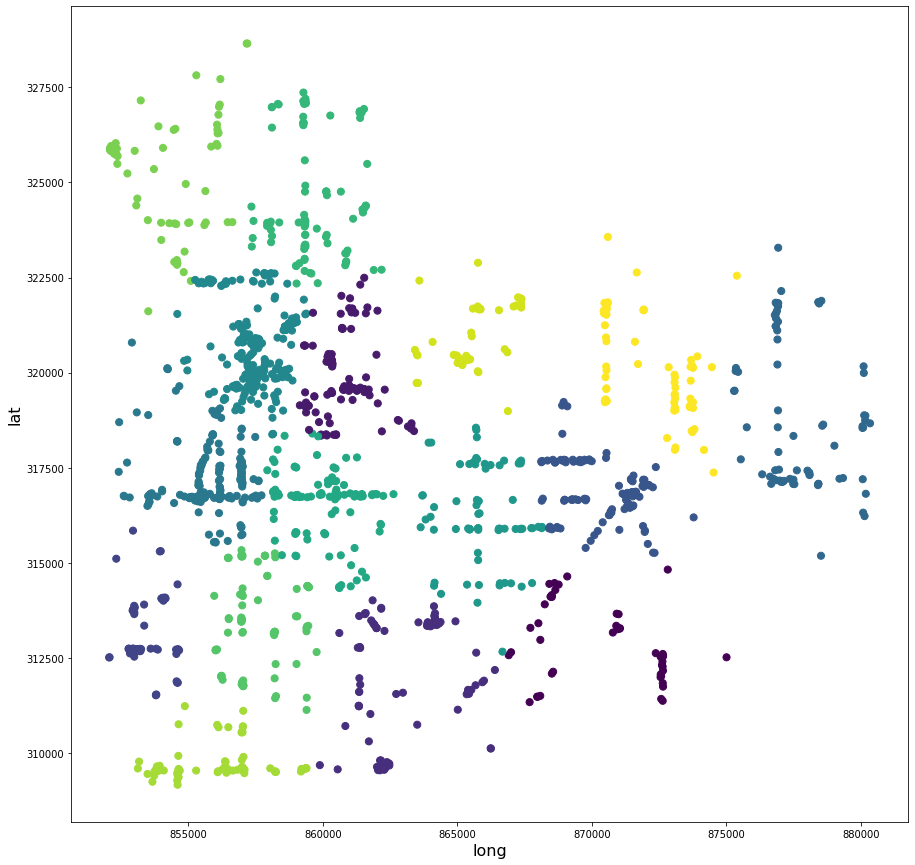

In [231]:
area = 10 * ( X[:, 0])**2  
fig = plt.figure(figsize=(15,15))
colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))

# Create a plot
ax = fig.add_subplot(1, 1, 1)


plt.scatter(X[:, 0], X[:, 1], s=50, c=labels.astype(np.float), alpha=2)
plt.xlabel('long', fontsize=16)
plt.ylabel('lat', fontsize=16)

plt.show()



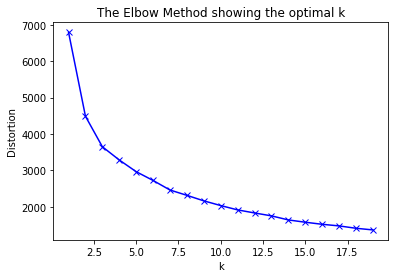

In [232]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


# k means determine k
distortions = []
K = range(1,20)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 30)
    k_means.fit(X)
    distortions.append(sum(np.min(cdist(X, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


## Cluster using DBSCAN

In [273]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = df_food_geo[['x','y','nearest_brew','within_r']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=.35, min_samples=8).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df_food_geo["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
print(realClusterNum)
#df_food_geo[['x','y','nearest_brew','within_r','Clus_Db']].head(5)
df_food_geo['Clus_Db'].value_counts()

21


 0     945
-1     176
 7      56
 8      43
 2      41
 11     36
 6      31
 9      27
 16     23
 5      22
 13     21
 20     19
 4      18
 19     18
 17     17
 15     16
 3      13
 1      12
 14     10
 12      9
 18      8
 10      8
Name: Clus_Db, dtype: int64

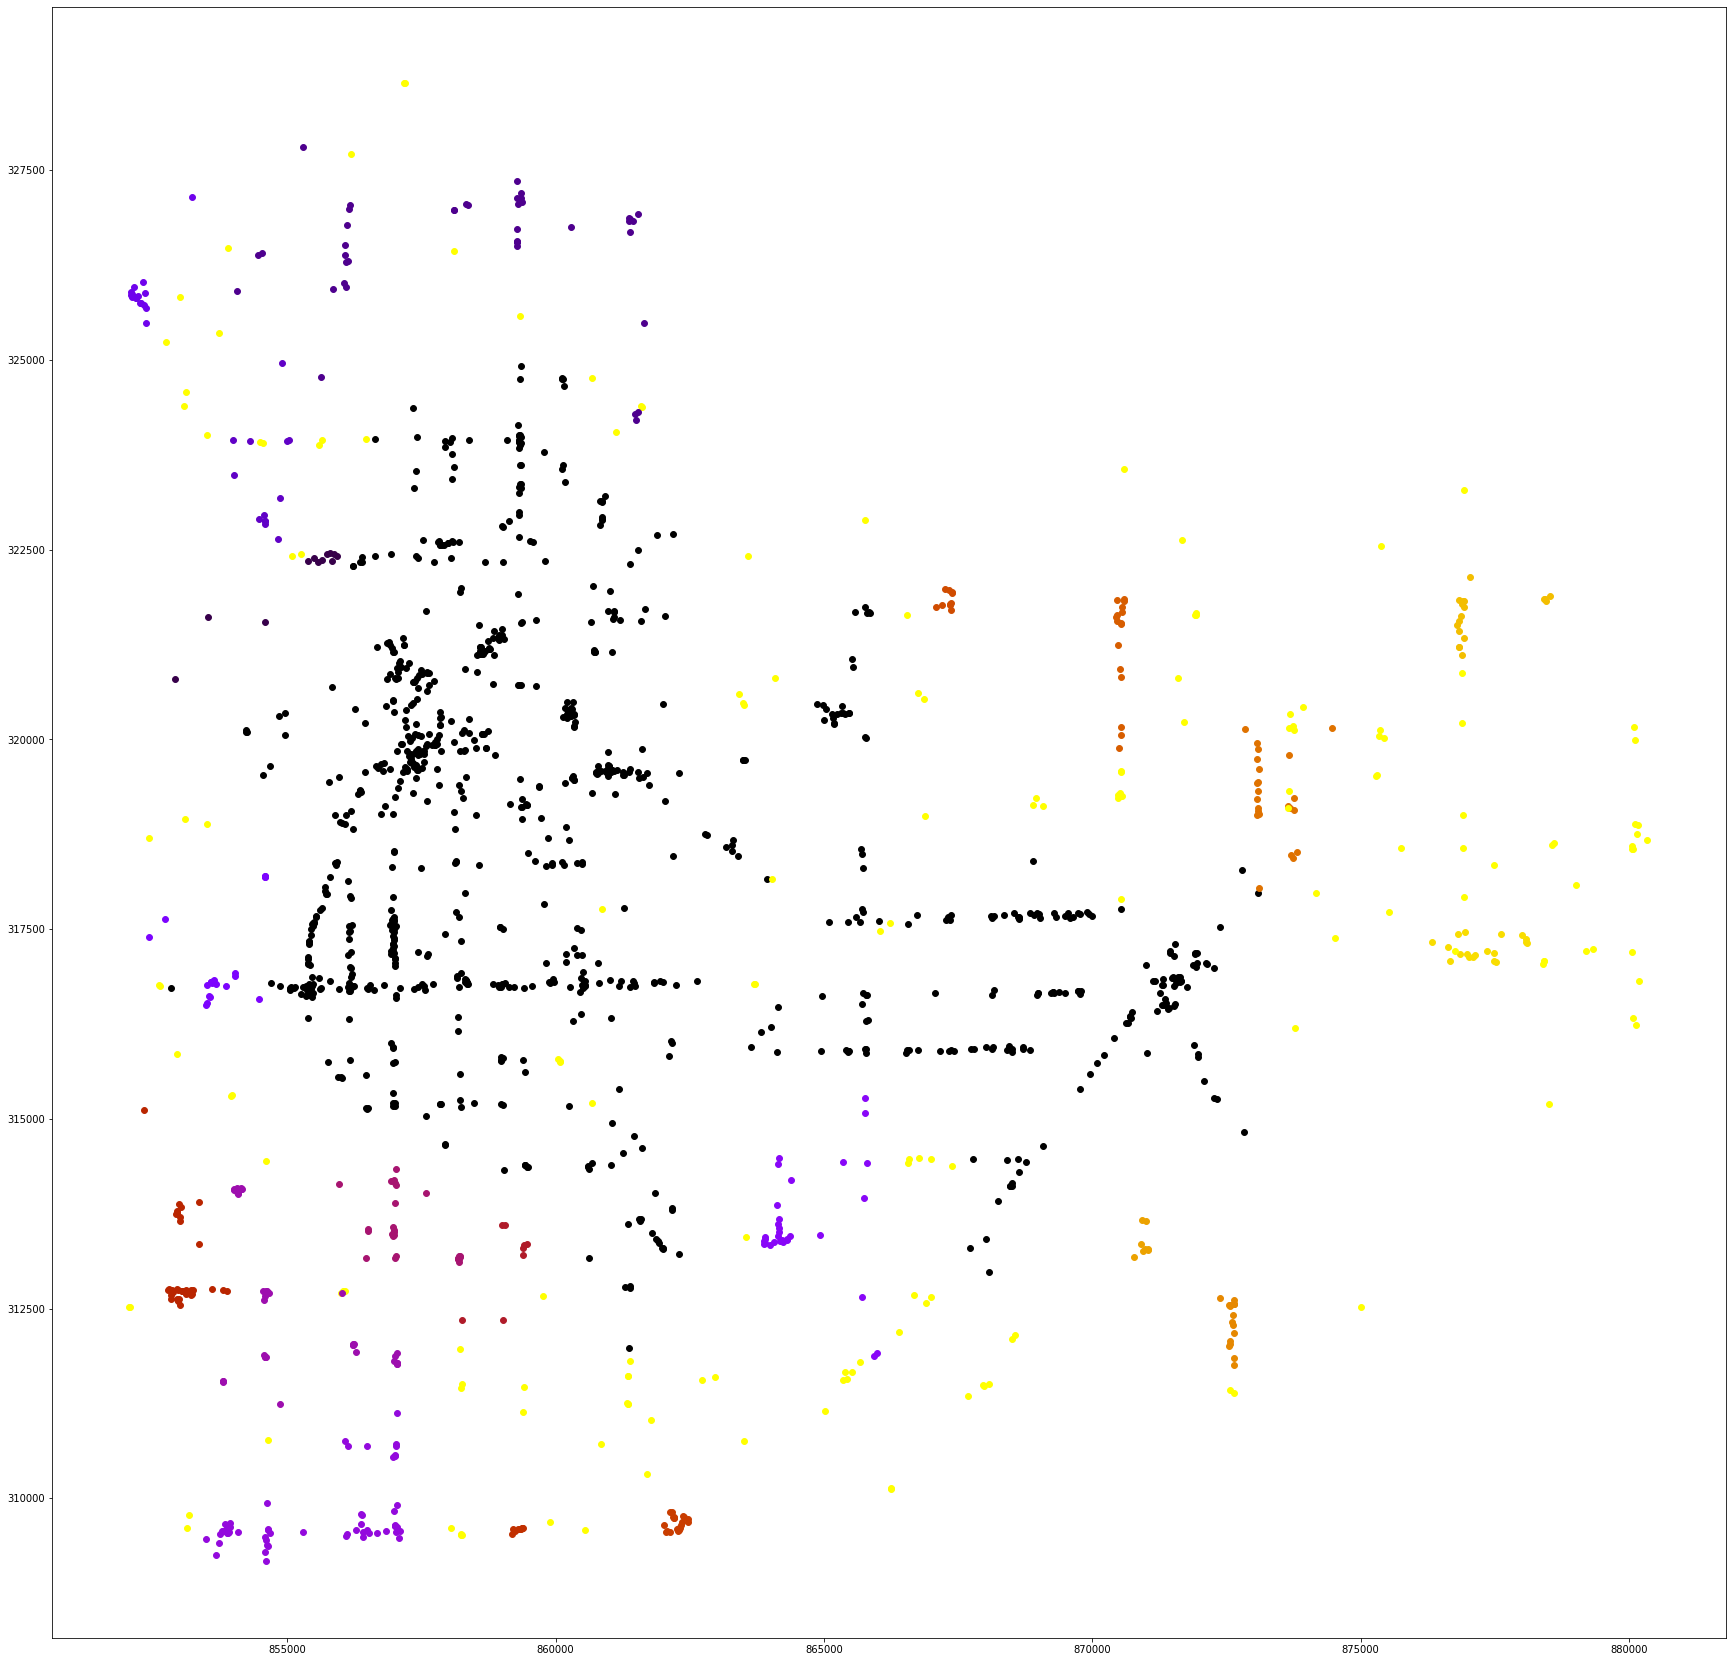

In [275]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize = (30,30))

colors = cm.gnuplot(np.linspace(0, 1, clusterNum))


for x, y, c in zip(df_food_geo['x'], df_food_geo['y'], colors[df_food_geo['Clus_Db']]):
    plt.scatter(x, y, 35, color=c)
    